# Navigation project using: DQN, DDQN, Dueling DQN & DDQN

In [1]:
# import the libraries used                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline
from Agent import agent

In [2]:
# Load the environement. Here you need to adjust the filename.
env = UnityEnvironment(file_name="../Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# We have, one agent that navigate in an environment composed of 37 states possible. 
# The state space has 37 dimensions that includes the agent's velocity and ray-based
# perception of objects in front of the agent. 
# The agent has 4 actions possible in each state:
#    0 - walk forward
#    1 - walk backward
#    2 - turn left
#    3 - turn right 

In [4]:
def initialize_env(env,train_mode=True,brain_id=0):
    # Here we take the brain number brain_id  and set it as the default brain.
    # Environments contain brains which are responsible for deciding the actions of their associated agents.
    # We use a single agent that move around in the environment
    brain_name = env.brain_names[brain_id]
    brain = env.brains[brain_name]
    
    # number of actions
    action_size = brain.vector_action_space_size
    
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:',state)

    state_size = len(state)
    print('States have length:', state_size)
    
    return brain_name, brain, env_info, action_size, state_size

In [5]:
def train(env,brain_name,agent,dqn,file_save='checkpoint.pth',n_episodes=700, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
 
    scores = []                        # list containing scores from each episode
    scores_mean=[]                     # list containing the mean score at each step
    scores_std=[]                      # list containing standart deviation at each step
    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # information about the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done,dqn)
 
            score += reward      # update the score
            state = next_state   # roll over the state to next time step
            if done:             # exit loop if episode finished
                break
 
        scores_window.append(score)                     # save most recent score
        scores.append(score)                            # save most recent score
        scores_mean.append(np.mean(scores_window))      # save most recent mean score last 100 scores
        scores_std.append(np.std(scores_window))        # save most recent standart deviation over last 100 scores        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon


        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
             
        #if i_episode % 10 == 0:         
           #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), file_save)
            break

    return scores,scores_mean, scores_std


In [6]:
def Test(env,brain_name,agent,file_name,max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    agent.qnetwork_local.load_state_dict(torch.load(file_name))
 
    scores = []                        # list containing scores from each episode
    score = 0

    env_info = env.reset(train_mode=False)[brain_name] 
    state = env_info.vector_observations[0]
    score = 0
    t=0
    for t in range(max_t):
        # select an action using a greedy policy
        action = agent.act(state)
        # take action in environment
        env_info = env.step(action)[brain_name]        # information about the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]  
        state = next_state   # roll over the state to next time step
        score += reward      # update the score
        scores.append(score)              # save most recent score
        if done or t>= max_t:
           break
    print("Average reward par step:",score/t)
    return scores

In [7]:
def plot_data(x,y,xlabel='Episode #',ylabel='Score',title="Results"):
  # plot the scores
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(x, y)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title, fontsize=16, fontweight='bold')
  plt.show()

## Training

In [8]:
brain_name, brain, env_info, action_size, state_size = initialize_env(env,train_mode=True,brain_id=0)

States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### DQN

In [9]:
dqn_agent = agent(state_size, action_size,duel=False, fc1_units=64,fc2_units=64,seed=0)
dqn_scores,dqn_scores_mean, dqn_scores_std  = train(env,brain_name,dqn_agent,dqn=True,file_save='dqn_checkpoint.pth')

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 1.17
Episode 200	Average Score: 4.27
Episode 300	Average Score: 6.85
Episode 400	Average Score: 8.64
Episode 500	Average Score: 10.60

Environment solved in 485 episodes!	Average Score: 13.03


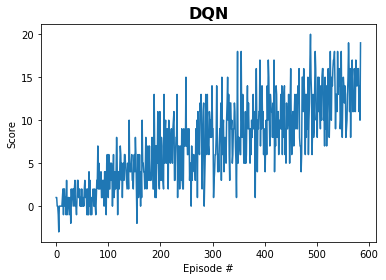

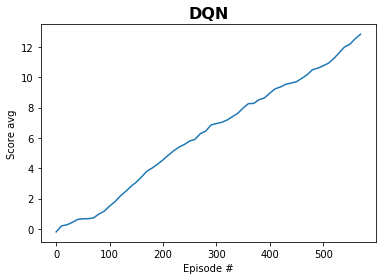

In [10]:
plot_data(np.arange(len(dqn_scores)),dqn_scores,xlabel='Episode #',ylabel='Score',title="DQN")
plot_data(np.arange(len(dqn_scores_mean)),dqn_scores_mean,xlabel='Episode #',ylabel='Score avg',title="DQN")

### DDQN

In [11]:
ddqn_agent = agent(state_size, action_size, duel=False, fc1_units=64,fc2_units=64,seed=0)
ddqn_scores,ddqn_scores_mean, ddqn_scores_std = train(env,brain_name,ddqn_agent,dqn=False,file_save='ddqn_checkpoint.pth')

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 0.70
Episode 200	Average Score: 2.88
Episode 300	Average Score: 8.02
Episode 400	Average Score: 10.13
Episode 500	Average Score: 11.80

Environment solved in 441 episodes!	Average Score: 13.03


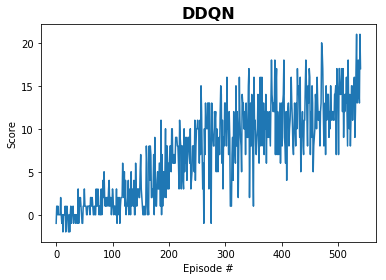

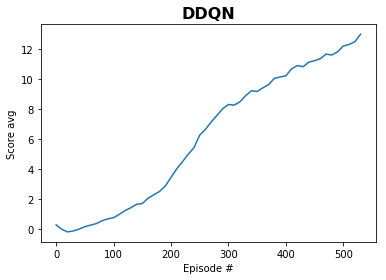

In [12]:
plot_data(np.arange(len(ddqn_scores)),ddqn_scores,xlabel='Episode #',ylabel='Score',title="DDQN")
plot_data(np.arange(len(ddqn_scores_mean)),ddqn_scores_mean,xlabel='Episode #',ylabel='Score avg',title="DDQN")

### Duelling DQN

In [13]:

duel_dqn_agent = agent(state_size, action_size,duel=True, fc1_units=64,fc2_units=64,seed=0)
duel_dqn_scores,duel_dqn_scores_mean,duel_dqn_scores_std = train(env,brain_name,duel_dqn_agent,dqn=True,file_save='duel_dqn_checkpoint.pth')

Duel_QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (V): Linear(in_features=64, out_features=1, bias=True)
  (A): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 0.57
Episode 200	Average Score: 4.09
Episode 300	Average Score: 7.40
Episode 400	Average Score: 9.35
Episode 500	Average Score: 11.55

Environment solved in 463 episodes!	Average Score: 13.06


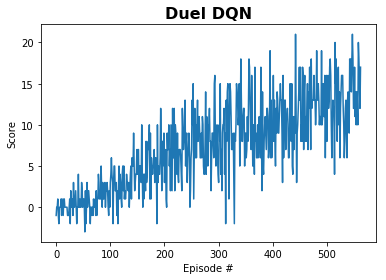

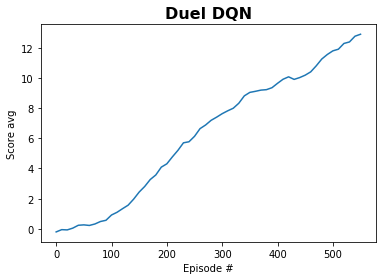

In [14]:
plot_data(np.arange(len(duel_dqn_scores)),duel_dqn_scores,ylabel='Score',title="Duel DQN")
plot_data(np.arange(len(duel_dqn_scores_mean)),duel_dqn_scores_mean_w,ylabel='Score avg',title="Duel DQN")

### Duelling DDQN

In [15]:
duel_ddqn_agent = agent(state_size, action_size, duel=True, fc1_units=64,fc2_units=64,seed=0)
duel_ddqn_scores,duel_ddqn_scores_mean,duel_ddqn_scores_std = train(env,brain_name,duel_ddqn_agent,dqn=False,file_save='duel_ddqn_checkpoint.pth')

Duel_QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (V): Linear(in_features=64, out_features=1, bias=True)
  (A): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 0.31
Episode 200	Average Score: 3.64
Episode 300	Average Score: 7.20
Episode 400	Average Score: 10.65
Episode 500	Average Score: 12.10

Environment solved in 432 episodes!	Average Score: 13.00


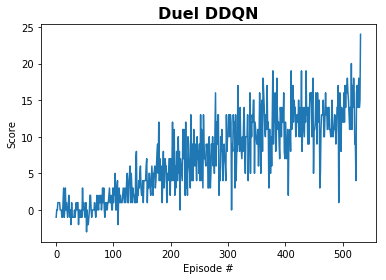

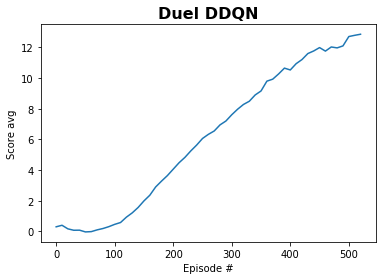

In [16]:
plot_data(np.arange(len(duel_ddqn_scores)),duel_ddqn_scores,ylabel='Score',title="Duel DDQN")
plot_data(np.arange(len(duel_ddqn_scores_mean)),duel_ddqn_scores_mean_w,ylabel='Score avg',title="Duel DDQN")

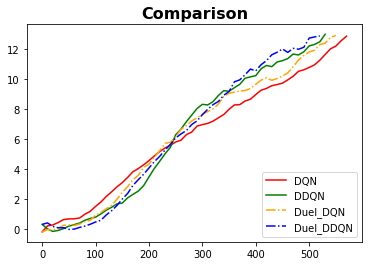

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores_mean)), dqn_scores_mean_w, color="red", label="DQN")
plt.plot(np.arange(len(ddqn_scores_mean)), ddqn_scores_mean_w, color="green", label="DDQN")
plt.plot(np.arange(len(duel_dqn_scores_mean)),duel_dqn_scores_mean_w,'-.',color="orange",label="Duel_DQN")
plt.plot(np.arange(len(duel_ddqn_scores_mean)),duel_ddqn_scores_mean_w,'-.',color="blue",label="Duel_DDQN")
plt.legend(loc='lower right')
plt.title("Comparison", fontsize=16, fontweight='bold')
plt.show()

## Testing

In [9]:
brain_name, brain, env_info, action_size, state_size = initialize_env(env,train_mode=True,brain_id=0)

States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


In [10]:
agent = agent(state_size, action_size,duel=False, fc1_units=64,fc2_units=64,seed=0)
file_name ='dqn_checkpoint.pth'

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
scores=Test(env,brain_name,agent,file_name ,max_t=1000)

In [ ]:
plot_data(np.arange(len(scores)),scores,xlabel='Step #',ylabel='DQN Score')


# Fin

In [ ]:
env.close()